<h2>Problem Definition</h2>

<h2>Solution Specification</h2>

<h2>Data Cleaning and Preprocessing</h2>

In [1]:
#import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
df = pd.read_json('image-data.json')
df.head()

,artists,comments,dates,downloads,faves,image_paths,image_urls,titles,views
0,get-sherlock,22.0,"January 17, 2014",91.0,142,[full/c11741fda71c47368b3ecc42de439de62c48cf30...,[https://images-wixmp-ed30a86b8c4ca887773594c2...,Sherlock,1593
1,Nadia-Ch,70.0,"August 26, 2013",NaN,900,[full/7dd4af05bd4fca98ce1688c899c444e3e6e12c0d...,[https://images-wixmp-ed30a86b8c4ca887773594c2...,Sherlock,9543
2,Unisha,42.0,"January 30, 2012",283.0,1560,[full/1e8b904f0bb82d4f5dfca301704d95e6cab4273d...,[https://images-wixmp-ed30a86b8c4ca887773594c2...,Sherlock,20886
3,Umino-aka-Morskaya,88.0,"September 7, 2010",193.0,1702,[full/240c5af33c8a67a4e9f69bcad604ab421e85c86c...,[https://images-wixmp-ed30a86b8c4ca887773594c2...,Sherlock,25432
4,DonPerico,102.0,"August 11, 2012",225.0,1961,[full/0f13dd8004eb7f0ce2b45c826f4e76df5978ac13...,[https://images-wixmp-ed30a86b8c4ca887773594c2...,SHERLOCK,21156


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2175 entries, 0 to 2174
Data columns (total 9 columns):
artists        2175 non-null object
comments       2169 non-null float64
dates          2175 non-null object
downloads      1613 non-null float64
faves          2175 non-null int64
image_paths    2175 non-null object
image_urls     2175 non-null object
titles         2175 non-null object
views          2175 non-null int64
dtypes: float64(2), int64(2), object(5)
memory usage: 153.0+ KB


In [12]:
#convert faves and comments to int
df['dates'] = pd.to_datetime(df['dates'])
df.head(5)


,artists,comments,dates,downloads,faves,image_paths,image_urls,titles,views
0,get-sherlock,22.0,2014-01-17,91.0,142,[full/c11741fda71c47368b3ecc42de439de62c48cf30...,[https://images-wixmp-ed30a86b8c4ca887773594c2...,Sherlock,1593
1,Nadia-Ch,70.0,2013-08-26,NaN,900,[full/7dd4af05bd4fca98ce1688c899c444e3e6e12c0d...,[https://images-wixmp-ed30a86b8c4ca887773594c2...,Sherlock,9543
2,Unisha,42.0,2012-01-30,283.0,1560,[full/1e8b904f0bb82d4f5dfca301704d95e6cab4273d...,[https://images-wixmp-ed30a86b8c4ca887773594c2...,Sherlock,20886
3,Umino-aka-Morskaya,88.0,2010-09-07,193.0,1702,[full/240c5af33c8a67a4e9f69bcad604ab421e85c86c...,[https://images-wixmp-ed30a86b8c4ca887773594c2...,Sherlock,25432
4,DonPerico,102.0,2012-08-11,225.0,1961,[full/0f13dd8004eb7f0ce2b45c826f4e76df5978ac13...,[https://images-wixmp-ed30a86b8c4ca887773594c2...,SHERLOCK,21156


In [43]:
#get number of days between image post date and oldest post date in dataset
df['time_period'] = (df['dates'] - df['dates'].min()).dt.days


In [14]:
#look at top 10 artists sorted by total number of favorites and comments
#no_of_posts shows their number of images within the database (not representative of entire post history)
artist_post_count = df.groupby('artists').agg({'faves':sum,
                           'comments': 'sum',
                           'image_urls':'count',
                          }).sort_values(by=['faves','comments','image_urls'],
                                         ascending=False).reset_index()
artist_post_count.rename(columns={'image_urls': 'no_of_posts'}, inplace=True)
artist_post_count.head(10)


,artists,faves,comments,no_of_posts
0,maXKennedy,42438,4751.0,52
1,dauntingfire,40741,3888.0,21
2,AmandaTolleson,38605,3944.0,11
3,mlcamaro,30289,1108.0,15
4,alicexz,23480,1144.0,3
5,hoo0,17311,885.0,3
6,xanseviera,13614,903.0,9
7,sakimichan,10923,451.0,1
8,sweetlittlekitty,10559,395.0,16
9,RoryonaRainbow,9744,506.0,4


In [45]:
#predicting popularity based on the artist's number of posts
df = pd.merge(df, artist_post_count.loc[:,['artists','no_of_posts']],
                  how='left', on='artists')
df.head()


,artists,comments,dates,downloads,faves,image_paths,image_urls,titles,views,time_period,no_of_posts
0,get-sherlock,22.0,2014-01-17,91.0,142,[full/c11741fda71c47368b3ecc42de439de62c48cf30...,[https://images-wixmp-ed30a86b8c4ca887773594c2...,Sherlock,1593,3522,6
1,Nadia-Ch,70.0,2013-08-26,0.0,900,[full/7dd4af05bd4fca98ce1688c899c444e3e6e12c0d...,[https://images-wixmp-ed30a86b8c4ca887773594c2...,Sherlock,9543,3378,9
2,Unisha,42.0,2012-01-30,283.0,1560,[full/1e8b904f0bb82d4f5dfca301704d95e6cab4273d...,[https://images-wixmp-ed30a86b8c4ca887773594c2...,Sherlock,20886,2804,2
3,Umino-aka-Morskaya,88.0,2010-09-07,193.0,1702,[full/240c5af33c8a67a4e9f69bcad604ab421e85c86c...,[https://images-wixmp-ed30a86b8c4ca887773594c2...,Sherlock,25432,2294,3
4,DonPerico,102.0,2012-08-11,225.0,1961,[full/0f13dd8004eb7f0ce2b45c826f4e76df5978ac13...,[https://images-wixmp-ed30a86b8c4ca887773594c2...,SHERLOCK,21156,2998,1


In [47]:
df.describe().round(2)

,comments,downloads,faves,views,time_period,no_of_posts
count,2175.00,2175.00,2175.00,2175.00,2175.00,2175.00
mean,54.44,300.69,458.96,10549.71,2993.89,4.76
std,85.91,1820.74,818.01,16274.29,551.78,8.57
min,0.00,0.00,11.00,167.00,0.00,1.00
25%,14.00,0.00,105.00,2082.00,2774.50,1.00
50%,28.00,29.00,202.00,4777.00,2889.00,2.00
75%,60.00,126.00,451.00,11756.50,3273.50,5.00
max,1056.00,63209.00,13068.00,191586.00,5303.00,52.00


<h2>Data Analysis</h2>

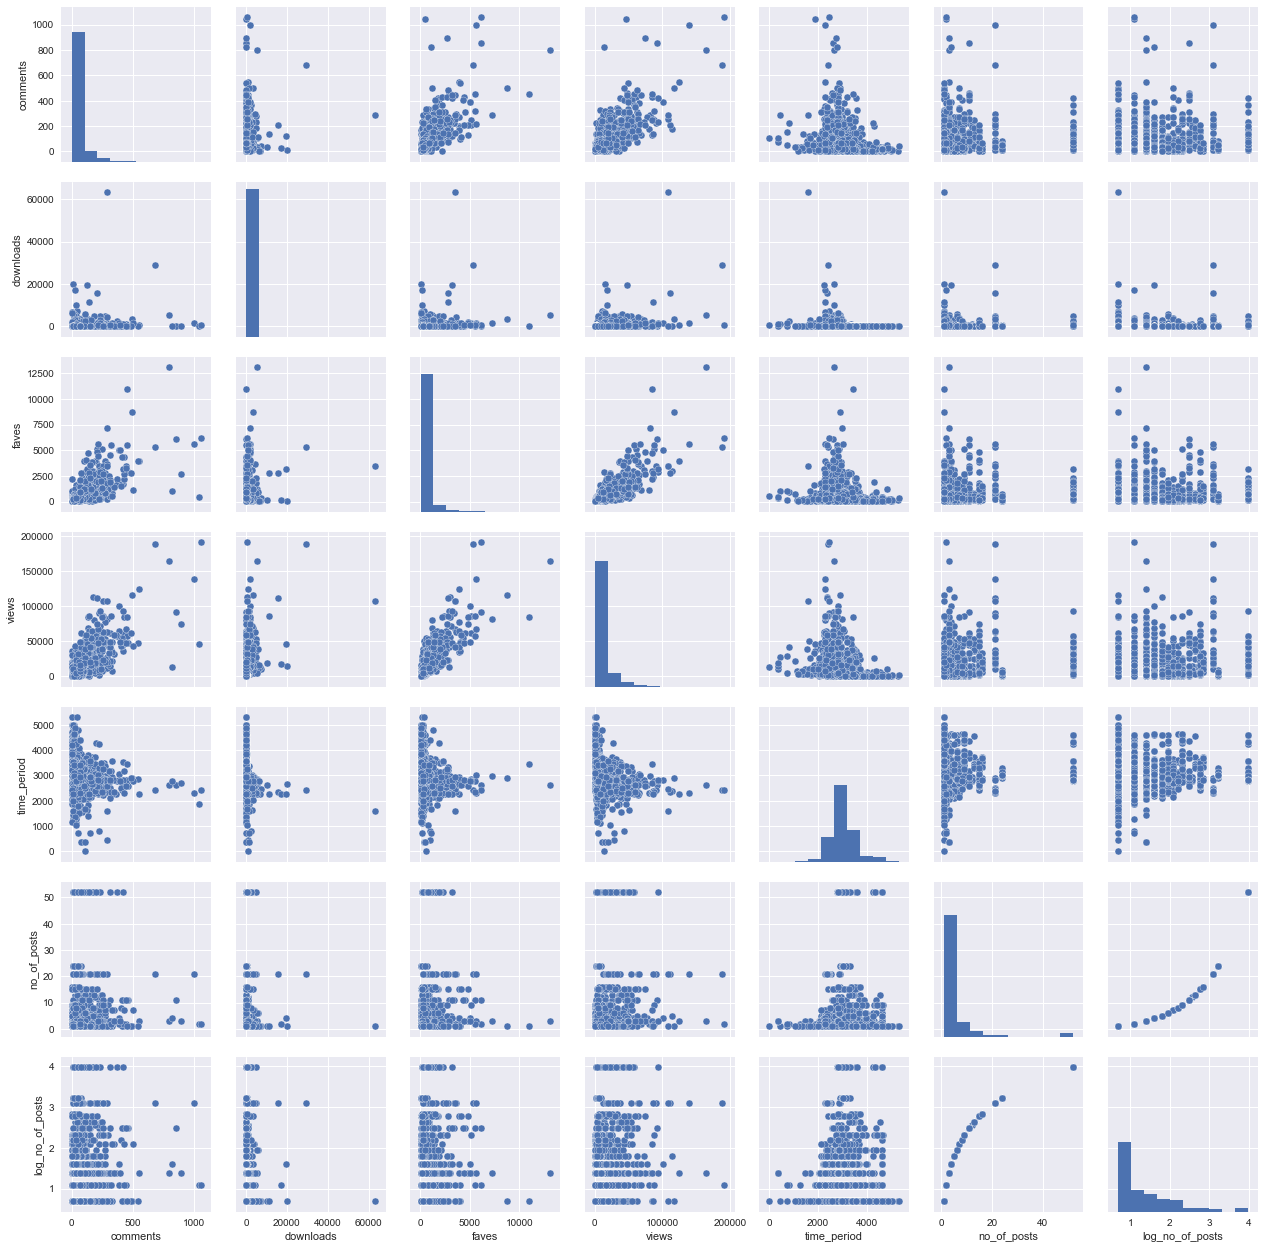

In [63]:
df.fillna(df.mean(), inplace=True)
df['log_no_of_posts'] = np.log(df['no_of_posts'] + 1)
sns.pairplot(df)

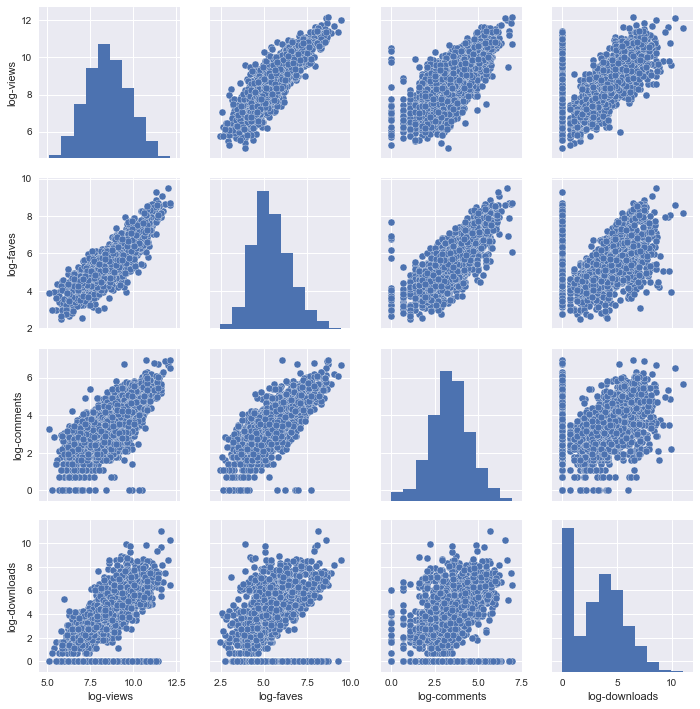

In [56]:
log_df = pd.DataFrame({"log-views": np.log(df['views'] + 1),
                        "log-faves": np.log(df['faves'] + 1),
                        "log-comments": np.log(df['comments'] + 1),
                        "log-downloads": np.log(df['downloads'] + 1)})
sns.pairplot(log_df)


Since a power law is observed in the distribution of faves, they are normalized by creating a log distribution of faves. The log-distribution resembles a Gaussian, which should make the training process easier.



<h2>Building Models</h2>

In [64]:
#linear models for social metric prediction
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import ElasticNetCV
from sklearn.model_selection import train_test_split

X = df[['time_period','no_of_posts']]
y = np.array(log_df['log-faves']).reshape(-1, 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

linear_reg = LinearRegression().fit(X_train, y_train)
ridge_reg = RidgeCV().fit(X_train, y_train)
elastic_reg = ElasticNetCV().fit(X_train, y_train.ravel())


In [65]:
from sklearn.metrics import r2_score, explained_variance_score, mean_absolute_error

def predict_score(model, X_test, y_test):
    
    predictions = model.predict(X_test)
    
    r2 = r2_score(y_test, predictions)
    expl_var = explained_variance_score(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)
    scores = [r2, expl_var, mae]
    
    return predictions, scores

lin_pred, lin_score = predict_score(linear_reg, X_test, y_test)
ridge_pred, ridge_score = predict_score(ridge_reg, X_test, y_test)
elastic_pred, elastic_score = predict_score(elastic_reg, X_test, y_test)


In [66]:
scores_df = pd.DataFrame(
            {"Algorithm": ["Linear regression","Ridge regression","Elastic Net Regression"],
            "r2 score":[lin_score[0],ridge_score[0],elastic_score[0]],
            "Explained variance score":[lin_score[1],ridge_score[1],elastic_score[1]],
            "Mean Absolute Error (log)": [lin_score[2],ridge_score[2],elastic_score[2]],
            "Mean Absolute Error (normalized)":[np.exp(lin_score[2]),np.exp(ridge_score[2]),np.exp(elastic_score[2])]})
scores_df


,Algorithm,r2 score,Explained variance score,Mean Absolute Error (log),Mean Absolute Error (normalized)
0,Linear regression,0.143926,0.145118,0.793465,2.211046
1,Ridge regression,0.143925,0.145118,0.793465,2.211045
2,Elastic Net Regression,0.143295,0.144588,0.793397,2.210894


<h2>CNN time</h2>

In [ ]:
from skimage.transform import resize
import matplotlib.image as mpimg

#create empty image lists
image_resized_lst = []
image_original_lst = []

#height and width of resized image
new_height = 250
new_width = 250


#image loading has to be done one-by-one to ensure that the images are loaded in the corresponding order to the
#data collected in the dataframe
for i in range(len(df)):
    my_dir = 'DA-images/'
    img_path = df['image_paths'][i][0]
    #load image
    img = mpimg.imread(my_dir + img_path)
    image_original_lst.append(img)
    #resize image
    img_resized = resize(img,(new_height,new_width),
                        mode='constant', anti_aliasing=True, anti_aliasing_sigma=None)
    image_resized_lst.append(img_resized)
    
original_arr = np.array(image_original_lst)
resized_arr = np.array(image_resized_lst)

In [ ]:
print(f"Original images array shape: {original_arr.shape}\nResized images array shape: {resized_arr.shape}")

In [ ]:
#peak at the resized images vs original images
fig, ax = plt.subplots(2, 6, figsize=(20, 10),
                       subplot_kw={'xticks':[], 'yticks':[]},
                       gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i in range(6):
    ax[0, i].imshow(original_arr[i])
    ax[1, i].imshow(resized_arr[i])
    ax[0, i].set_title(f"Faves: {df.faves[i]}")
    
ax[0, 0].set_ylabel('Images Original',size=15)
ax[1, 0].set_ylabel('Images Resized',size=15)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.wrappers.scikit_learn import KerasRegressor

input_shape = (250,250,3)

def baseline_model():
    # create model
    model = Sequential()

    model.add(Conv2D(32, kernel_size=(9, 9), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Flatten())
    
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
    
    return model

In [ ]:
# build regression estimator
estimator = KerasRegressor(build_fn=baseline_model, epochs=10, batch_size=20, verbose=1, validation_split=0.2)


In [ ]:
X = resized_arr
y = np.array(log_faves)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

In [ ]:
estimator.fit(X_train, y_train)

In [ ]:
y_train = np.exp(y_train)
prediction = estimator.predict(X_train)
prediction = np.exp(prediction)

plt.figure(figsize=(20,6))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.grid(False)
    plt.axis('off')
    plt.title(f"Real Faves: {y_train[i]}, \nPredicted Faves: {np.floor(prediction[i])}")
    plt.imshow(X_train[i])
    
print(f"Explained variance score: {explained_variance_score(y_train, prediction)}")
print(f"Mean absolute error: {mean_absolute_error(y_train, prediction)}")

In [ ]:


prediction = estimator.predict(X_test)
prediction = np.exp(prediction)
y_test = np.exp(y_test)

plt.figure(figsize=(20,6))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.grid(False)
    plt.axis('off')
    plt.title(f"Real Faves: {y_test[i]}, \nPredicted Faves: {np.floor(prediction[i])}")
    plt.imshow(X_test[i])
    
print(f"Explained variance score: {explained_variance_score(y_test, prediction)}")
print(f"Mean absolute error: {mean_absolute_error(y_test, prediction)}")

Ideas to improve the model:
- only select pics of a certain dimension? e.g. filter out pics that are too long or too tall.